# Flux analysis, homocysteine tracing

In [1]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.stats import norm

In [2]:
from common import *

In [3]:
from simpleflux.model import FluxModel, FluxState
from simpleflux.modelstate import ModelState
from simpleflux.fitting import ModelFit

## Define model

### Stoichiometry

In [5]:
stoichiometry = defaultdict(int, {
    ('HCYS_IN', 'hcys'): 1,
    ('PROT_SYNTH', 'met'): -1, ('PROT_SYNTH', 'metp'): 1, 
    ('AHCY', 'sah'): -1, ('AHCY', 'hcys'): 1, 
    ('METS', 'hcys'): -1, ('METS', 'met'): 1, 
    ('MAT', 'met'): -1, ('MAT', 'sam'): 1, 
    ('SAM_METH', 'sam'): -1, ('SAM_METH', 'sah'): 1, 
    ('CYSTS', 'hcys'): -1, ('CYSTS', 'cyst'): 1,
    ('CYSTL', 'cyst'): -1, ('CYSTL', 'akb'): 1,
    ('MET_OUT', 'met'): -1,
    ('PROT_OUT', 'metp'): -1,
    ('AKB_OUT', 'akb'): -1,
})

reversible_reactions = [
    'HCYS_IN',
    'PROT_SYNTH',
    'AHCY',
    'CYSTL',
]

free_reactions = ['CYSTS', 'METS', 'PROT_OUT', 'SAM_METH']

flux_model = FluxModel(stoichiometry, reversible_reactions, free_reactions)

In [6]:
flux_model.get_stoichiometry_df()

,AHCY,AKB_OUT,CYSTL,CYSTS,HCYS_IN,MAT,METS,MET_OUT,PROT_OUT,PROT_SYNTH,SAM_METH
akb,0,-1,1,0,0,0,0,0,0,0,0
cyst,0,0,-1,1,0,0,0,0,0,0,0
hcys,1,0,0,-1,1,0,-1,0,0,0,0
met,0,0,0,0,0,-1,1,-1,0,-1,0
metp,0,0,0,0,0,0,0,0,-1,1,0
sah,-1,0,0,0,0,0,0,0,0,0,1
sam,0,0,0,0,0,1,0,0,0,0,-1


## D4-homocysteine tracing

### Pool sizes

Estimated intracellular concentrations in M

In [7]:
estimated_conc = pd.read_csv(derived_data_path / 'D4_hcys_cell_concentrations.csv', index_col=[0, 1], header=[0,1])\
    .reorder_levels(['cell_type', 'metabolite'])\
    .sort_index()
estimated_conc.columns = ['mean', 'std_dev']

In [8]:
additional_conc = pd.DataFrame(
    [
        (23500, 2350),
        (23500, 2350),
        (1000, 1000),
        (1000, 1000),                
    ],
    columns=['mean', 'std_dev'],
    index=pd.MultiIndex.from_tuples(
        [
            ('BJ-TERT', 'metp'),
            ('BJ-RAS', 'metp'),
            ('BJ-TERT', 'akb'),
            ('BJ-RAS', 'akb'),
        ],
        names=['cell_type', 'metabolite']
    )
)

In [9]:
pool_size_data = pd.concat([estimated_conc * 1e6, additional_conc])\
    .sort_index(ascending=[False, True])
pool_size_data

mean      std_dev
cell_type metabolite                           
BJ-TERT   akb          1000.000000  1000.000000
          cyst           34.041334     4.875644
          hcys          126.816081     5.402064
          met             2.695766     0.317128
          metp        23500.000000  2350.000000
          sah             5.337056     0.083814
          sam            15.785999     5.724782
BJ-RAS    akb          1000.000000  1000.000000
          cyst           18.962894     1.072726
          hcys          204.787985     8.687905
          met             2.328592     0.119824
          metp        23500.000000  2350.000000
          sah             6.948340     0.183748
          sam            28.774918     6.103437

### Measured fluxes

Measured fluxes (pmol / h * uL cells = uM / h).

In [10]:
release_fluxes = pd.read_csv(derived_data_path / 'D4_hcys_release_flux.csv', index_col=[0, 1], header=[0,1])
release_fluxes

release_pmol_h_uLcells             
                                       mean          std
metabolite cell_type                                    
hcys       BJ-RAS              -2703.150893    39.195548
           BJ-TERT             -2687.807126  2191.468048
met        BJ-RAS                  3.604628     0.905095
           BJ-TERT                16.501548     8.867638

Manually select flux and combine with protein estimate

In [11]:
prot_out_estimates = {'BJ-TERT': 337, 'BJ-RAS': 49}
prot_out_rel_err = 0.2

In [12]:
measured_fluxes = pd.DataFrame(
    [
        tuple(release_fluxes.loc[('met', 'BJ-TERT')]),
        (prot_out_estimates['BJ-TERT'], prot_out_estimates['BJ-TERT'] * prot_out_rel_err),
        tuple(release_fluxes.loc[('met', 'BJ-RAS')]),
        (prot_out_estimates['BJ-RAS'], prot_out_estimates['BJ-RAS'] * prot_out_rel_err),
    ],
    columns=['mean', 'std_dev'],
    index=pd.MultiIndex.from_tuples(
        [
            ('BJ-TERT', 'MET_OUT'),
            ('BJ-TERT', 'PROT_OUT'),
            ('BJ-RAS', 'MET_OUT'),
            ('BJ-RAS', 'PROT_OUT'),
        ],
        names=['cell_type', 'flux']
    )
)
measured_fluxes

mean    std_dev
cell_type flux                           
BJ-TERT   MET_OUT    16.501548   8.867638
          PROT_OUT  337.000000  67.400000
BJ-RAS    MET_OUT     3.604628   0.905095
          PROT_OUT   49.000000   9.800000

### Heavy fractions

In [13]:
# drop methionine data (not reliable)
heavy_fractions = pd.read_csv(derived_data_path / 'D4-hcys_heavy_fractions.csv', index_col=[0, 1, 2])\
    .drop('met', axis=1)
# use time in hours
heavy_fractions.index = heavy_fractions.index\
    .set_levels(heavy_fractions.index.levels[1].astype('float64') / 60, level=1)\
    .rename(['cell_type', 'time_hours', 'replicate_nr'])
heavy_fractions.head(5)

cyst      hcys       sah       sam
cell_type time_hours replicate_nr                                            
BJ-RAS    0.083333   1            -4.593566e-07  0.973315  0.090056  0.058944
                     2            -4.593566e-07  0.976601  0.097586  0.057966
          0.250000   1            -4.593566e-07  0.976907  0.144331  0.102804
                     2            -4.593566e-07  0.983596  0.165651  0.116804
          0.500000   1             3.206148e-02  0.972768  0.222937  0.192457

In [14]:
heavy_fraction_mean = heavy_fractions.groupby(level=[0, 1]).mean()
heavy_fraction_mean

cyst      hcys       sah       sam
cell_type time_hours                                            
BJ-RAS    0.083333   -4.593566e-07  0.974958  0.093821  0.058455
          0.250000   -4.593566e-07  0.980252  0.154991  0.109804
          0.500000    2.473517e-02  0.974808  0.257078  0.203058
          1.000000    5.208494e-02  0.966340  0.362543  0.318602
          5.000000    4.347830e-01  0.966880  0.544890  0.527086
          24.000000   8.277716e-01  1.000000  0.720305  0.656083
BJ-TERT   0.083333   -4.593566e-07  0.966341  0.110916  0.089081
          0.250000   -4.593566e-07  0.983303  0.221635  0.169860
          0.500000    1.301532e-02  0.976673  0.349556  0.204238
          1.000000    3.159986e-02  0.964477  0.462107  0.273886
          5.000000    3.603861e-01  1.000000  0.644316  0.412310
          24.000000   8.977940e-01  1.000000  0.638767  0.512422

In [15]:
min_std_dev = 0.02
heavy_fraction_sd = np.maximum(heavy_fractions.groupby(level=[0, 1]).std(), min_std_dev)
heavy_fraction_sd

cyst      hcys       sah       sam
cell_type time_hours                                        
BJ-RAS    0.083333    0.020000  0.020000  0.020000  0.020000
          0.250000    0.020000  0.020000  0.020000  0.020000
          0.500000    0.020000  0.020000  0.048283  0.020000
          1.000000    0.020000  0.020000  0.033905  0.020000
          5.000000    0.020000  0.020000  0.020000  0.020000
          24.000000   0.020000  0.020000  0.020000  0.020417
BJ-TERT   0.083333    0.020000  0.020000  0.021059  0.020000
          0.250000    0.020000  0.023614  0.020000  0.020000
          0.500000    0.020000  0.020000  0.020000  0.020000
          1.000000    0.020000  0.020000  0.024549  0.031353
          5.000000    0.026899  0.020000  0.021608  0.020000
          24.000000   0.020000  0.020000  0.020000  0.020000

### Initial flux state

In [16]:
init_flux_state = FluxState.from_dict(
    flux_model,
    free_fluxes={
        'CYSTS' : 7,
        'METS': 350,
        'SAM_METH': 30,
        'PROT_OUT': 500,
    },
    exchanges={
        'HCYS_IN' : 0.9,
        'PROT_SYNTH': 0.4,
        'AHCY': 0.9,
        'CYSTL': 0.4,
    }
)

In [17]:
initial_state = ModelState(
    model=flux_model,
    flux_state=init_flux_state,
    concentrations=pool_size_data.loc['BJ-TERT'].loc[flux_model.metabolites, 'mean'].to_numpy(),
    medium_mi={'HCYS_IN': 1.0}
)

In [18]:
flux_model.get_flux_table(init_flux_state)

,net_flux,fwd_flux,rev_flux
AHCY,30.0,300.000000,270.000000
AKB_OUT,7.0,7.000000,0.000000
CYSTL,7.0,11.666667,4.666667
CYSTS,7.0,7.000000,0.000000
HCYS_IN,327.0,3270.000000,2943.000000
MAT,30.0,30.000000,0.000000
METS,350.0,350.000000,0.000000
MET_OUT,-180.0,-180.000000,-0.000000
PROT_OUT,500.0,500.000000,0.000000
PROT_SYNTH,500.0,833.333333,333.333333


### Fit model

In [19]:
cell_types = ['BJ-TERT', 'BJ-RAS']

In [20]:
measured_fluxes.loc['BJ-RAS'].index

Index(['MET_OUT', 'PROT_OUT'], dtype='object', name='flux')

In [21]:
model_fits = {
    cell_type: ModelFit(
        initial_state,
        measured_mi = heavy_fraction_mean.loc[cell_type],
        measured_mi_std_dev = heavy_fraction_sd.loc[cell_type],
        measured_fluxes=measured_fluxes.loc[cell_type],
        measured_conc=pool_size_data.loc[cell_type]
    )
    for cell_type in cell_types
}

Initial residuals

In [22]:
[model_fits[cell_type].model_residual() for cell_type in cell_types]

[array([ -0.49 ,   4.974, -28.068,   2.395,  -2.065,  -0.28 , -34.145,
          0.296,  -3.689,  -0.834, -28.658,  -4.553,  -6.775,  -1.513,
        -19.384,  -4.995,  -4.862,   0.206, -14.195,  -6.759,  12.648,
          0.146, -16.325,  -8.333,  22.159,  -2.418,   0.   ,   0.   ,
          0.   ,   0.   ,   0.   ,   0.   ,   0.   ]),
 array([ -0.49 ,   5.405, -30.409,   0.864,  -2.065,  -0.483, -37.477,
         -2.707,  -3.103,  -0.927, -13.786,  -4.612,  -5.751,  -1.419,
        -16.972,  -5.594,  -2.819,  -1.45 , -20.307,  -1.02 ,   9.147,
          0.146, -12.248,  -1.126, 202.857, -46.02 ,   0.   , -14.056,
          8.975,  -3.064,   0.   ,   8.769,   2.128])]

Fit models

In [23]:
for cell_type in cell_types:
    model_fits[cell_type].fit()

In [24]:
model_fits['BJ-TERT'].minimizer_result.params

name,value,standard error,relative error,initial value,min,max,vary
CYSTS,3.00268381,0.82430373,(27.45%),7,0.01000000,1000.00000,True
METS,290.067417,74.1655732,(25.57%),350,0.01000000,1000.00000,True
PROT_OUT,258.114410,73.4537828,(28.46%),500,0.01000000,1000.00000,True
SAM_METH,16.5171968,5.44401995,(32.96%),30,0.01000000,1000.00000,True
AHCY_EX,0.30165045,0.04351476,(14.43%),0.9,0.00000000,0.99900000,True
CYSTL_EX,1.6330e-07,0.08737693,(53507242.79%),0.4,0.00000000,0.99900000,True
HCYS_IN_EX,0.95711926,0.02379902,(2.49%),0.9,0.00000000,0.99900000,True
PROT_SYNTH_EX,0.64479179,0.02978846,(4.62%),0.4,0.00000000,0.99900000,True
akb,999.639014,1588.16512,(158.87%),1000.0,100.000000,10000.0000,True
cyst,33.9867630,7.74332651,(22.78%),34.041333977697086,3.40413340,340.413340,True


In [25]:
flux_model.get_flux_table(model_fits['BJ-TERT'].model_state.flux_state)

,net_flux,fwd_flux,rev_flux
AHCY,16.517197,23.651761,7.134564e+00
AKB_OUT,3.002684,3.002684,0.000000e+00
CYSTL,3.002684,3.002684,4.903361e-07
CYSTS,3.002684,3.002684,0.000000e+00
HCYS_IN,276.552904,6449.349435,6.172797e+03
MAT,16.517197,16.517197,0.000000e+00
METS,290.067417,290.067417,0.000000e+00
MET_OUT,15.435811,15.435811,0.000000e+00
PROT_OUT,258.114410,258.114410,0.000000e+00
PROT_SYNTH,258.114410,726.656662,4.685423e+02


In [26]:
flux_model.get_flux_table(model_fits['BJ-RAS'].model_state.flux_state)

,net_flux,fwd_flux,rev_flux
AHCY,33.599286,39.779844,6.180558
AKB_OUT,2.113185,2.113185,0.000000
CYSTL,2.113185,2.427977,0.314792
CYSTS,2.113185,2.113185,0.000000
HCYS_IN,66.493245,10726.064447,10659.571202
MAT,33.599286,33.599286,0.000000
METS,97.979346,97.979346,0.000000
MET_OUT,3.645315,3.645315,0.000000
PROT_OUT,60.734745,60.734745,0.000000
PROT_SYNTH,60.734745,137.485671,76.750926


### Residuals

In [27]:
[
    pd.DataFrame(
        model_fits[cell_type].isotope_residual(),
        columns=heavy_fraction_mean.loc[cell_type].columns,
        index=heavy_fraction_mean.loc[cell_type].index
    )
    for cell_type in cell_types
]

[                cyst      hcys       sah       sam
 time_hours                                        
 0.083333   -0.281020 -0.804643  1.609938  2.564122
 0.250000   -1.004252 -0.584895 -0.204080  2.292826
 0.500000   -1.420938 -1.048067 -0.557653 -0.555524
 1.000000   -2.558323 -1.681823 -1.006435 -1.301283
 5.000000    0.186977  0.075430  2.642568  0.060905
 24.000000   0.958978  0.061086 -1.347390 -0.531226,
                 cyst      hcys       sah       sam
 time_hours                                        
 0.083333   -0.356783 -0.451831  2.157930  1.646668
 0.250000   -1.263582 -0.828582  0.207507  0.487648
 0.500000   -1.353705 -1.120945  0.015169  0.488431
 1.000000   -2.517248 -1.570281 -0.931169 -0.428786
 5.000000    1.254197 -1.587008 -4.094067 -1.636216
 24.000000  -0.188769  0.063314  3.148997  3.002637]

### Model fit statistics

In [28]:
from scipy.stats import chi2

In [29]:
n_param = len(model_fits['BJ-TERT'].minimizer_result.params)
n_data_points = len(model_fits['BJ-TERT'].model_residual())
[n_param, n_data_points]

[15, 33]

Degrees of freedom and $\chi^2$ critical value

In [30]:
model_fit_level = 0.05
degrees_freedom = model_fits['BJ-TERT'].minimizer_result.nfree
[degrees_freedom, chi2.isf(model_fit_level, degrees_freedom)]

[18, 28.869299430392637]

Sum of squared residuals and model rejection p-values

In [31]:
pd.DataFrame(
    [
        [
            model_fits[cell_type].minimizer_result.chisqr,
            1 - chi2.cdf(model_fits[cell_type].minimizer_result.chisqr, degrees_freedom)
        ]
        for cell_type in cell_types
    ],
    index=cell_types, columns=['chi_square', 'p_value']
)

,chi_square,p_value
BJ-TERT,45.401451,3.625242e-04
BJ-RAS,70.068244,4.400727e-08


### Plot fitted data

In [32]:
t_simulated = np.arange(0, 24, 0.05)

In [33]:
def plot_file_name(cell_type: str, log_scale: bool) -> str:
    plot_name = 'D4-hcys_fitted_data'
    if log_scale:
        scale_suffix = 'logscale'
    else:
        scale_suffix = 'linscale'
    return "_".join([plot_name, cell_type, scale_suffix]) + '.pdf'

In [34]:
x_simulated = pd.concat(
    [
        prepend_index_level(
            model_fits[cell_type].model_state.simulate_to_pandas(t_simulated),
            cell_type, name='cell_type'
        )
        for cell_type in cell_types
    ]
)

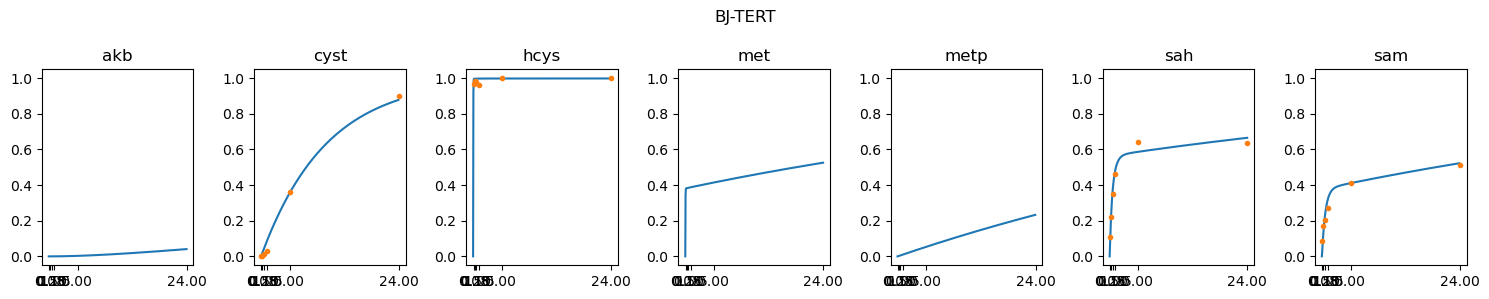

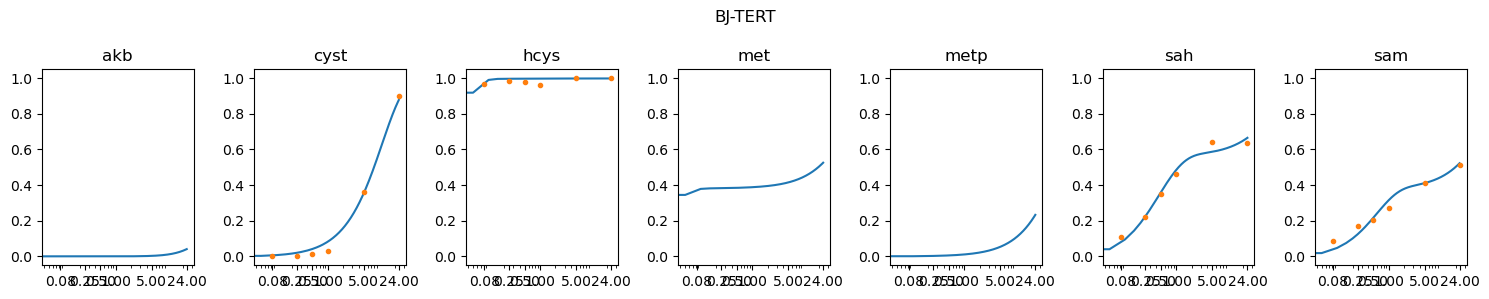

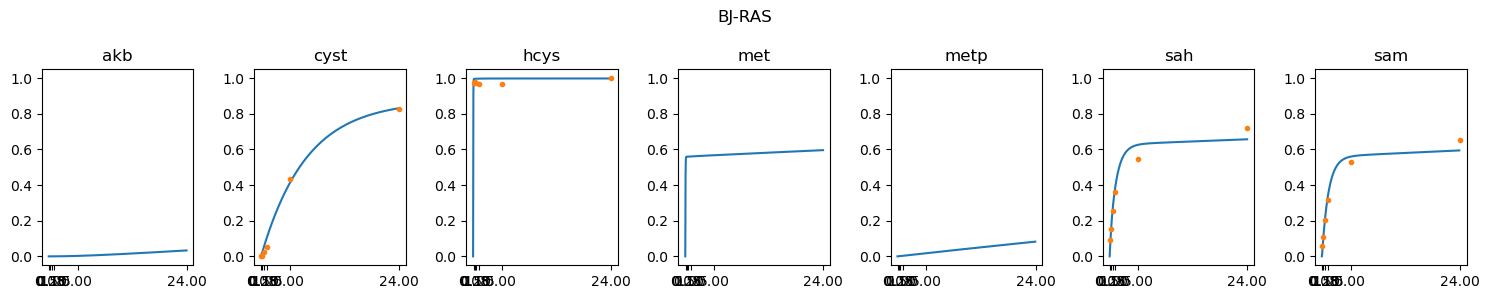

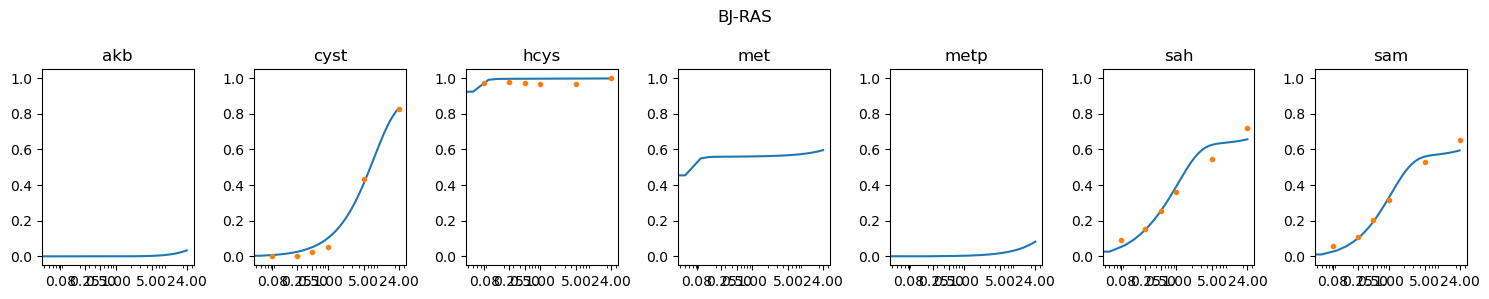

In [35]:
for cell_type in cell_types:
    for use_log_scale in [False, True]:
        plot_model_fit(
            flux_model, x_simulated.loc[cell_type], heavy_fraction_mean.loc[cell_type],
            use_log_scale=use_log_scale
        )
        plt.suptitle(cell_type)
        plt.tight_layout()
        plt.savefig(plots_path / plot_file_name(cell_type, use_log_scale))

### Confidence intervals on estimated net fluxes
These are two-sided linearized confidence intervals, based on the parameter covariance from lmfit

In [38]:
ci_reactions = ['CYSTS', 'HCYS_IN', 'METS', 'MET_OUT', 'PROT_OUT', 'SAM_METH']
ci_table = pd.concat(
    [
        prepend_index_level(
            confidence_intervals_table(flux_model, model_fits[cell_type], ci_level=0.9).loc[ci_reactions],
            cell_type, name='cell_type'
        )
        for cell_type in cell_types
    ]
)
ci_table

net    std err  ci_half-width    ci_lower  \
cell_type reaction                                                     
BJ-TERT   CYSTS       3.002684   0.824304       1.355859    1.646825   
          HCYS_IN   276.552904  73.946363     121.630944  154.921960   
          METS      290.067417  74.165573     121.991512  168.075905   
          MET_OUT    15.435811  14.060181      23.126940   -7.691129   
          PROT_OUT  258.114410  73.453783     120.820721  137.293689   
          SAM_METH   16.517197   5.444020       8.954616    7.562581   
BJ-RAS    CYSTS       2.113185   0.373083       0.613667    1.499518   
          HCYS_IN    66.493245  18.906584      31.098564   35.394681   
          METS       97.979346  22.090292      36.335297   61.644049   
          MET_OUT     3.645315   1.785672       2.937169    0.708146   
          PROT_OUT   60.734745  18.814839      30.947656   29.787089   
          SAM_METH   33.599286  11.052983      18.180540   15.418746   

                      ci_upper  
cell_type reaction              
BJ-TERT   CYSTS       4.358543  
          HCYS_IN   398.183848  
          METS      412.058929  
          MET_OUT    38.562750  
          PROT_OUT  378.935131  
          SAM_METH   25.471813  
BJ-RAS    CYSTS       2.726852  
          HCYS_IN    97.591808  
          METS      134.314643  
          MET_OUT     6.582484  
          PROT_OUT   91.682400  
          SAM_METH   51.779826

In [40]:
# since seaborn (strangely) does not support drawing error bars from specified values,
# we provide the (max, min) range as values and plot using median (midrange) and max/min for error bars
ci_table_for_seaborn = ci_table[['ci_lower', 'ci_upper']].melt(ignore_index=False).sort_index(ascending=[False, True]).reset_index()

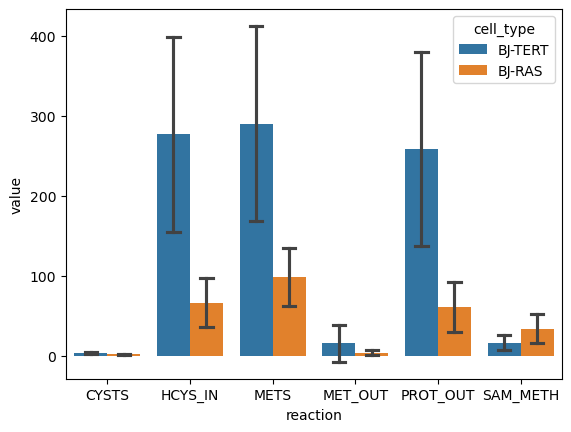

In [43]:
sns.barplot(
    ci_table_for_seaborn,
    x='reaction', y='value', hue='cell_type',
    estimator=np.median, errorbar=lambda x: [x.min(), x.max()], capsize=0.3
)
plt.savefig(plots_path / 'D4-hcys_flux_ci.pdf')